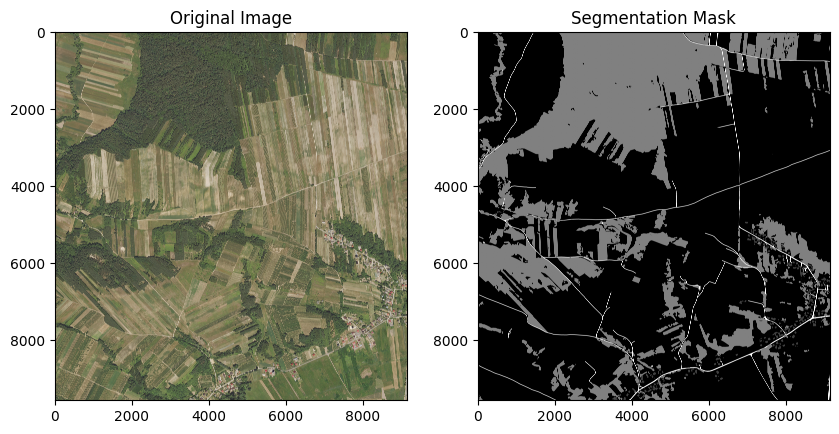

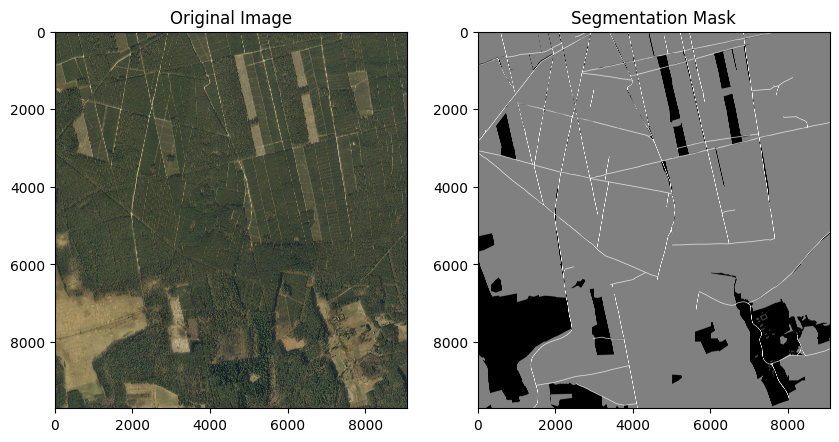

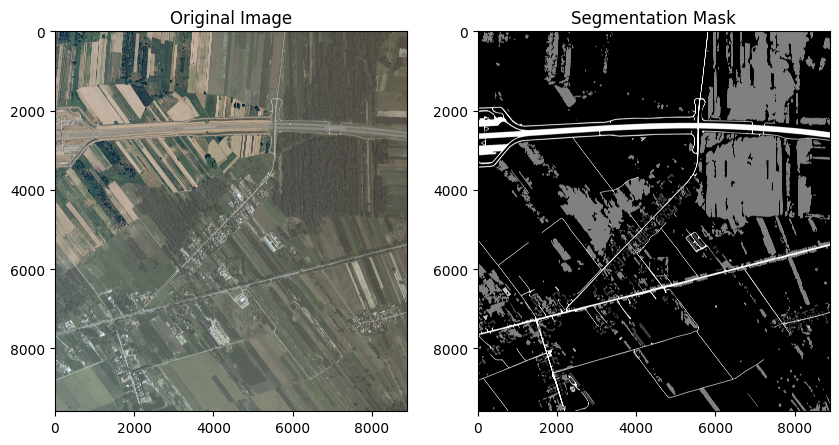

Processing images: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s]

✅ Preprocessing complete! 41 image-mask pairs saved in 'data/processed/'
Train: 28, Val: 8, Test: 5


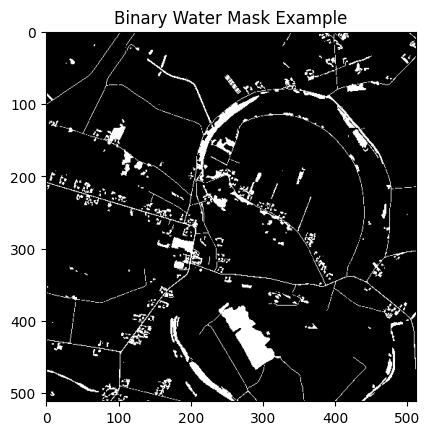

In [13]:
# ===============================================
# 01_data_prep.ipynb
# Dataset visualization + preprocessing pipeline
# ===============================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Paths
RAW_IMG_DIR = "/Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/data/raw/images"
RAW_MASK_DIR = "/Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/data/raw/masks"
PROC_IMG_DIR = "/Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/data/processed/images"
PROC_MASK_DIR = "/Users/dhruvkumartiwari/Desktop/Dhruv_CODING/water-boundary-detector/data/processed/masks"

os.makedirs(PROC_IMG_DIR, exist_ok=True)
os.makedirs(PROC_MASK_DIR, exist_ok=True)

# ---------------------------------------------------
# STEP 1: Inspect few samples
# ---------------------------------------------------
sample_imgs = os.listdir(RAW_IMG_DIR)[:3]

for fname in sample_imgs:
    img_path = os.path.join(RAW_IMG_DIR, fname)
    mask_path = os.path.join(RAW_MASK_DIR, fname)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)  # grayscale

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Segmentation Mask")
    plt.show()

# ---------------------------------------------------
# STEP 2: Define constants and helper functions
# ---------------------------------------------------
IMAGE_SIZE = 512  # resize target

# You may need to check which pixel value corresponds to "water" in mask
# For LandCover.ai, 'water' is usually 3, but verify by inspecting the mask.
WATER_CLASS_ID = 3  

def preprocess_image_mask(img_path, mask_path):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    mask_resized = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

    # Convert to binary mask (water=255, else=0)
    binary_mask = np.where(mask_resized == WATER_CLASS_ID, 255, 0).astype("uint8")

    return img_resized, binary_mask

# ---------------------------------------------------
# STEP 3: Process and save all data (Final Fixed)
# ---------------------------------------------------
from PIL import Image

img_files = os.listdir(RAW_IMG_DIR)
processed_count = 0

for fname in tqdm(img_files, desc="Processing images"):
    img_path = os.path.join(RAW_IMG_DIR, fname)
    
    # Mask has the SAME name as image, no "_mask" suffix
    mask_path = os.path.join(RAW_MASK_DIR, fname)
    
    if not os.path.exists(mask_path):
        print(f"⚠️ Skipping (no mask found): {fname}")
        continue

    # Use Pillow for .tif reading (macOS-safe)
    img = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    mask_resized = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

    # Convert to binary mask: any nonzero pixel = 255
    binary_mask = (mask_resized > 0).astype("uint8") * 255

    # Save as .png for better compatibility
    out_name = os.path.splitext(fname)[0] + ".png"
    cv2.imwrite(os.path.join(PROC_IMG_DIR, out_name), img_resized)
    cv2.imwrite(os.path.join(PROC_MASK_DIR, out_name), binary_mask)

    processed_count += 1

print(f"✅ Preprocessing complete! {processed_count} image-mask pairs saved in 'data/processed/'")


# ---------------------------------------------------
# STEP 4: Train/Validation/Test split
# ---------------------------------------------------
images = sorted(os.listdir(PROC_IMG_DIR))
train_files, valtest_files = train_test_split(images, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(valtest_files, test_size=0.33, random_state=42)

def write_list(fname, file_list):
    with open(fname, "w") as f:
        for item in file_list:
            f.write("%s\n" % item)

write_list("../data/train.txt", train_files)
write_list("../data/val.txt", val_files)
write_list("../data/test.txt", test_files)

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

# ---------------------------------------------------
# STEP 5: Sanity check for binary masks
# ---------------------------------------------------
sample_mask = cv2.imread(os.path.join(PROC_MASK_DIR, test_files[0].replace('.jpg', '_mask.png')), 0)
plt.imshow(sample_mask, cmap='gray')
plt.title("Binary Water Mask Example")
plt.show()


In [14]:
import os

PROC_IMG_DIR = "../data/processed/images"
PROC_MASK_DIR = "../data/processed/masks"

print("Processed images:", len(os.listdir(PROC_IMG_DIR)))
print("Processed masks:", len(os.listdir(PROC_MASK_DIR)))

print("\nSample processed image files:", os.listdir(PROC_IMG_DIR)[:5])


Processed images: 41
Processed masks: 41

Sample processed image files: ['M-34-51-C-d-4-1.png', 'M-33-48-A-c-4-4.png', 'M-34-68-B-a-1-3.png', 'N-33-60-D-d-1-2.png', 'N-34-106-A-b-3-4.png']
